Demonstration for XImage operations

In [1]:
import astropy.units as u
import numpy
import xarray
from astropy.coordinates import SkyCoord

from rascil.data_models import PolarisationFrame
from rascil.processing_components.simulation.testing_support import create_test_image

/Users/timcornwell/opt/anaconda3/envs/rascil37/lib/python3.7/typing.py:850: FutureWarning: xarray subclass Configuration should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)
/Users/timcornwell/opt/anaconda3/envs/rascil37/lib/python3.7/typing.py:850: FutureWarning: xarray subclass GainTable should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)
/Users/timcornwell/opt/anaconda3/envs/rascil37/lib/python3.7/typing.py:850: FutureWarning: xarray subclass PointingTable should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)
/Users/timcornwell/opt/anaconda3/envs/rascil37/lib/python3.7/typing.py:850: FutureWarning: xarray subclass Image should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)
/Users/timcornwell/opt/anaconda3/envs/rascil37/lib/python3.7/typing.py:850: FutureWarning: xarray subclass GridData should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)
/Users/timco

Create  suitable test image

In [2]:
frequency = numpy.linspace(1.0e8, 1.1e8, 8)
phasecentre = SkyCoord(ra=+180.0 * u.deg, dec=-35.0 * u.deg, frame='icrs', equinox='J2000')

ximg = create_test_image(cellsize=0.001, phasecentre=phasecentre, frequency=frequency,
                         polarisation_frame=PolarisationFrame("stokesIQUV"))

assert numpy.max(ximg.data) > 0.0

print(ximg)

AttributeError: 'Image' object has no attribute 'data'

Show channel 0, stokes I image

In [5]:
import matplotlib.pyplot as plt
ximg2d = ximg.sel({"frequency": frequency[0], "polarisation": "I"})
print(ximg2d)

<xarray.Image>
Dimensions:       (l: 256, m: 256)
Coordinates:
    frequency     float64 1e+08
    polarisation  <U1 'I'
  * m             (m) float64 34.96 34.96 34.97 34.97 ... 35.03 35.04 35.04
  * l             (l) float64 -0.03556 -0.03528 -0.035 ... 0.035 0.03528 0.03556
Data variables:
    pixels        (m, l) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    shape:               (8, 4, 256, 256)
    phasecentre:         <SkyCoord (ICRS): (ra, dec) in deg\n    (0., 35.)>
    wcs:                 WCS Keywords\n\nNumber of WCS axes: 4\nCTYPE : 'RA--...
    polarisation_frame:  stokesIQUV


In [ ]:
ximg2d.plot.imshow()
plt.show()

Select I, V polarisations

In [4]:
print(ximg.sel({"polarisation": ["I", "V"]}))

# Apply a mask to the data
ximg.data = ximg.data.where(numpy.hypot(ximg.data["l"] - numpy.mean(ximg.data["l"]),
                                        ximg.data["m"] - numpy.mean(ximg.data["m"])) < 0.03)

<xarray.DataArray (frequency: 8, polarisation: 2, l: 256, m: 256)>
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
...
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.

In [5]:
print(ximg)
print(numpy.sum(ximg.data))

Image:
<xarray.DataArray (frequency: 8, polarisation: 4, l: 256, m: 256)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., na

Apply a function across the image in chunks using dask transparently

In [6]:
ximg.data = ximg.data.chunk({"l": 32, "l": 32})
print(ximg)
ximg.data = xarray.apply_ufunc(numpy.sqrt, ximg.data,
                               dask="parallelized",
                               output_dtypes=[float])

Image:
<xarray.DataArray (frequency: 8, polarisation: 4, l: 256, m: 256)>
dask.array<xarray-<this-array>, shape=(8, 4, 256, 256), dtype=float64, chunksize=(8, 4, 32, 256), chunktype=numpy.ndarray>
Coordinates:
  * frequency     (frequency) float64 1e+08 1.014e+08 ... 1.086e+08 1.1e+08
  * polarisation  (polarisation) <U1 'I' 'Q' 'U' 'V'
  * l             (l) float64 -0.03556 -0.03528 -0.035 ... 0.035 0.03528 0.03556
  * m             (m) float64 34.96 34.96 34.97 34.97 ... 35.03 35.04 35.04
	Shape: (8, 4, 256, 256)
	Data type: float64
	WCS: WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'STOKES'  'FREQ'  
CRVAL : 180.0  -35.0  1.0  100000000.0  
CRPIX : 129.0  129.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.05729577951308232  0.05729577951308232  1.0  1428571.4285714328  
NAXIS : 0  0
	Polarisat

Show the resulting image

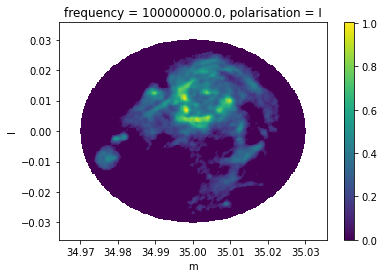

In [7]:
ximg.data = ximg.data.sel({"frequency": frequency[0], "polarisation": "I"})
ximg.data.plot.imshow()
plt.show()
